In [1]:
%load_ext autoreload
%autoreload -p 2

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import torch
from ipywidgets import HBox, IntSlider, VBox, interactive_output
from matplotlib import ticker

from curvelets.numpy.udct import UDCT, SimpleUDCT
from curvelets.plot import create_colorbar, despine
from curvelets.torch.udct import UDCT as TorchUDCT

In [3]:
def make_r(
    shape: tuple[int, ...], exponent: float = 1, origin: tuple[int, ...] | None = None
):
    orig = (
        tuple((np.asarray(shape).astype(float) - 1) / 2) if origin is None else origin
    )

    ramps = np.meshgrid(*[np.arange(s, dtype=float) - o for s, o in zip(shape, orig)], indexing="ij")
    return sum(x**2 for x in ramps) ** (exponent / 2)


def make_zone_plate(shape: tuple[int, ...], amplitude: float = 1.0, phase: float = 0.0):
    mxsz = max(*shape)

    return amplitude * np.cos((np.pi / mxsz) * make_r(shape, 2) + phase)

In [42]:
shape = (32, 64)
zone_plate = make_zone_plate(shape)
print(zone_plate.shape)
cfg = np.array([[3, 3, 3], [3, 3, 6]])
C = UDCT(shape=shape, cfg=cfg)
# C = SimpleUDCT(shape, nscales=3, nbands_per_direction=3, alpha=0.5)


# %%
# Uniform Discrete Curvelet Transform Round Trip
# ##############################################

coeffs = C.forward(zone_plate)
zone_plate2= C.backward(coeffs)

(32, 64)


In [43]:
coeffs_vec = C.vect(coeffs=coeffs)
coeffs_img = []
for i in range(0, len(coeffs_vec) - zone_plate.size, zone_plate.size):
    coeffs_img.append(coeffs_vec[i : i + zone_plate.size].reshape(1, *zone_plate.shape))
if len(coeffs_vec) % zone_plate.size != 0:
    coeffs_img.append(np.zeros((1, *zone_plate.shape), dtype=coeffs_vec.dtype))
    coeffs_img[-1].flat[
        len(coeffs_vec) - zone_plate.size : len(coeffs_vec)
    ] = coeffs_vec[len(coeffs_vec) - zone_plate.size :]
coeffs_img = np.concatenate(coeffs_img, axis=0)

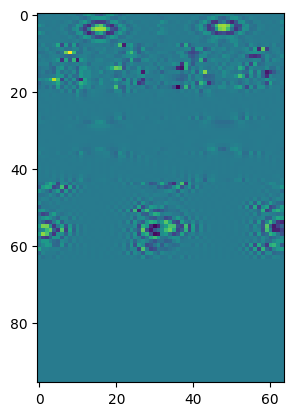

In [44]:
fig, ax = plt.subplots()
ax.imshow(np.concatenate(coeffs_img.real, axis=0))

In [5]:
Ct = TorchUDCT(shape=shape, cfg=cfg)
with torch.autocast(device_type="cpu"):
    zone_plate_tensor = torch.as_tensor(zone_plate).to(torch.float16)
    coeffs_tensor = Ct.forward(zone_plate_tensor)
    zone_plate_tensor2 = Ct.backward(coeffs_tensor)
coeffs_tensor[0][0][0].dtype

torch.complex64

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x754d98b84b50>)

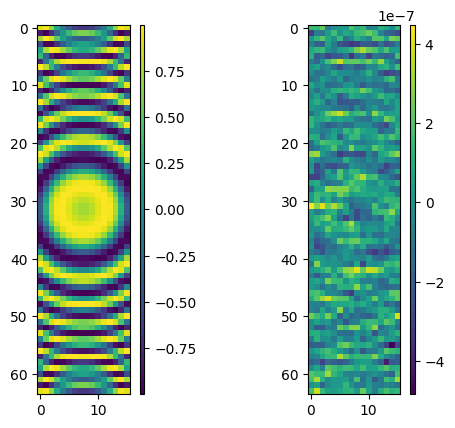

In [64]:
fig, ax = plt.subplots(1, 2)
vmax = np.abs(zone_plate2).max()
im = ax[0].imshow(zone_plate2[0], vmin=-vmax, vmax=vmax)
create_colorbar(im, ax[0])
im = ax[1].imshow(zone_plate2[0] - zone_plate_tensor2[0].numpy())
create_colorbar(im, ax[1])

In [5]:
len(coeffs[0][0][0])

16

In [7]:
coeffs2 = C.struct(C.vect(coeffs))
for c, _ in enumerate(coeffs):
    for d, _ in enumerate(coeffs[c]):
        for a, _ in enumerate(coeffs[c][d]):
            np.testing.assert_allclose(coeffs[c][d][a], coeffs2[c][d][a])

In [10]:
from functools import reduce
from operator import iconcat

reduce(iconcat, coeffs.values(), [])

AttributeError: 'list' object has no attribute 'values'

In [4]:
coeffs[0][0][0].shape

(16, 32, 8)

In [10]:
for c in coeffs:
    print(f"Scale {c}")
    for d in coeffs[c]:
        print(f"    Direction {d}: {coeffs[c][d][0].shape}")
        print(f"               : {C.decimation[c][d]}")
        print("                ", shape // C.decimation[c][d])
    print()

Scale 0
    Direction 0: (16, 32, 8)
               : [2 2 2]
                 [16 32  8]

Scale 1
    Direction 0: (8, 16, 4)
               : [4 4 4]
                 [ 8 16  4]
    Direction 1: (8, 16, 4)
               : [4 4 4]
                 [ 8 16  4]
    Direction 2: (8, 16, 4)
               : [4 4 4]
                 [ 8 16  4]

Scale 2
    Direction 0: (16, 16, 4)
               : [2 4 4]
                 [16 16  4]
    Direction 1: (8, 32, 4)
               : [4 2 4]
                 [ 8 32  4]
    Direction 2: (8, 16, 8)
               : [4 4 2]
                 [ 8 16  8]



In [11]:
for c in coeffs:
    print(f"Scale {c}")
    for d in coeffs[c]:
        print(f"    Direction {d}: {len(coeffs[c][d])}")
        for a in coeffs[c][d]:
            print(f"        ", coeffs[c][d][a].shape)

Scale 0
    Direction 0: 1
         (16, 32, 8)
Scale 1
    Direction 0: 9
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
    Direction 1: 9
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
    Direction 2: 9
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
         (8, 16, 4)
Scale 2
    Direction 0: 36
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
         (16, 16, 4)
    

In [7]:
def zero_coeffs(coeffs):
    z = {}
    for c in coeffs:
        z[c] = {}
        for d in coeffs[c]:
            z[c][d] = {}
            for a in coeffs[c][d]:
                z[c][d][a] = np.zeros_like(coeffs[c][d][a])
    return z

In [8]:
i0 = 0#coeffs[1][0][0].shape[0] // 2 + 1
i1 = 0#coeffs[1][0][0].shape[1] // 2 + 1
dirac_coeffs = zero_coeffs(coeffs=coeffs)
dirac_coeffs[1][0][0][i0, i1] = 1
dirac_space = C.backward(dirac_coeffs)

TypeError: Invalid shape (16, 64, 32) for image data

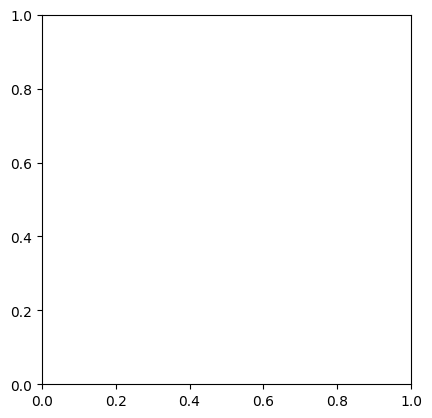

In [9]:
fig, ax = plt.subplots()
ax.imshow(dirac_space.T)

In [36]:
for c in coeffs:
    print(f"Scale {c}")
    for d in coeffs[c]:
        print(f"    Direction {d}: {len(coeffs[c][d])}")
        for a in coeffs[c][d]:
            print(f"        ", coeffs[c][d][a].shape)

Scale 0
    Direction 0: 1
         (64, 128)
Scale 1
    Direction 0: 3
         (32, 64)
         (32, 64)
         (32, 64)
    Direction 1: 5
         (22, 64)
         (22, 64)
         (22, 64)
         (22, 64)
         (22, 64)
Scale 2
    Direction 0: 6
         (64, 64)
         (64, 64)
         (64, 64)
         (64, 64)
         (64, 64)
         (64, 64)
    Direction 1: 6
         (64, 128)
         (64, 128)
         (64, 128)
         (64, 128)
         (64, 128)
         (64, 128)


/tmp/ipykernel_276171/331480755.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 5))


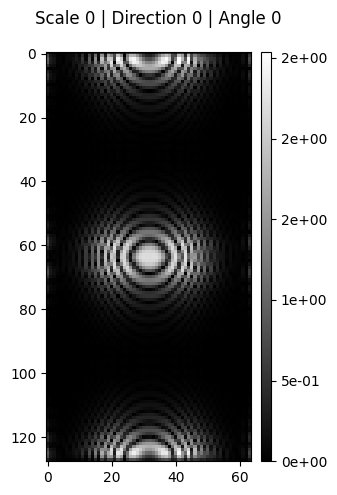

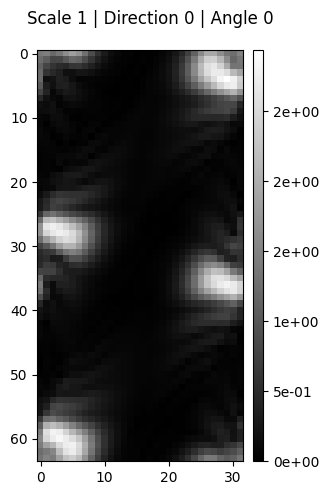

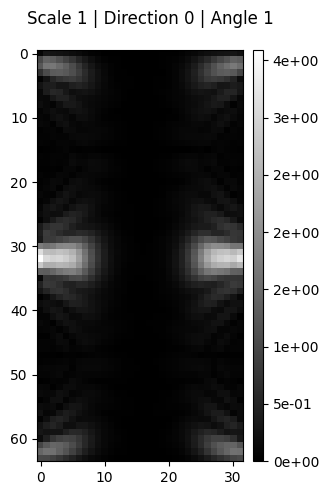

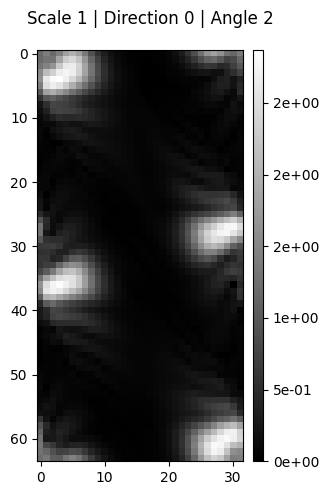

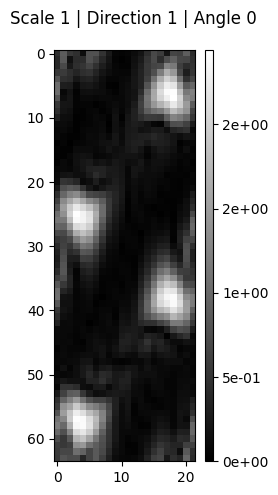

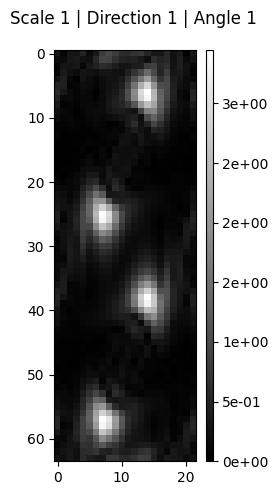

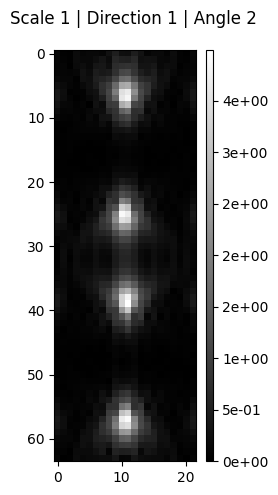

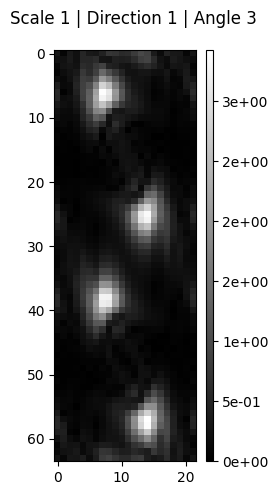

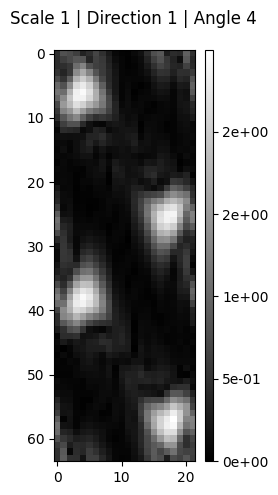

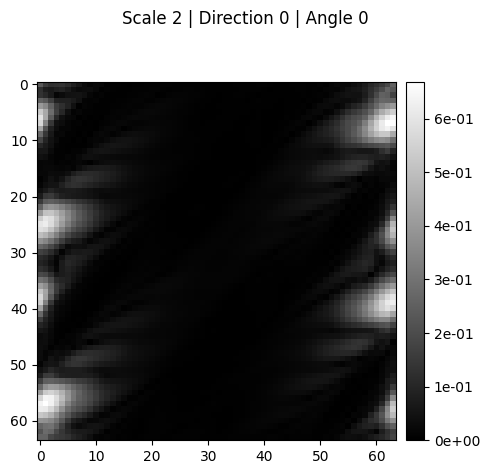

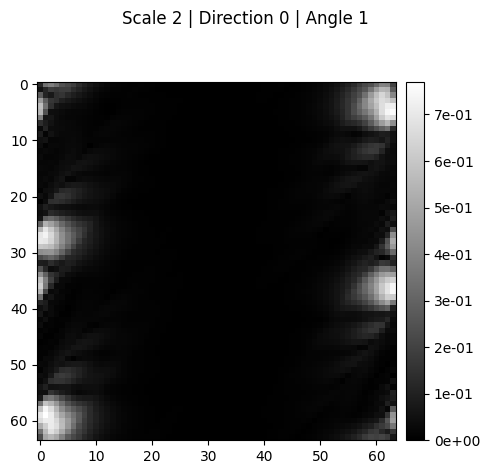

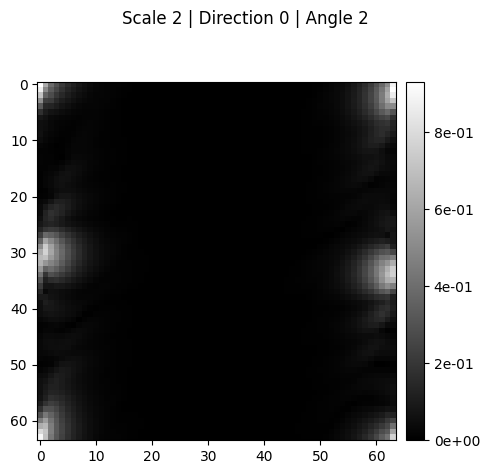

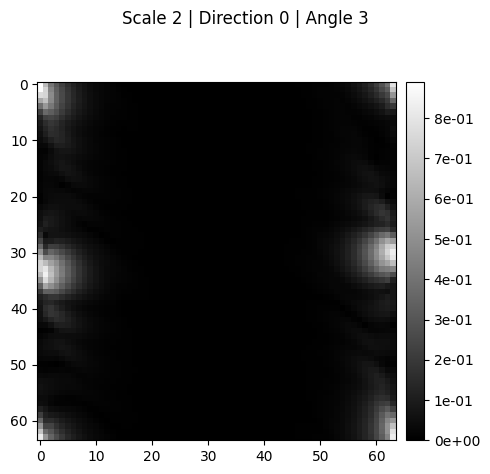

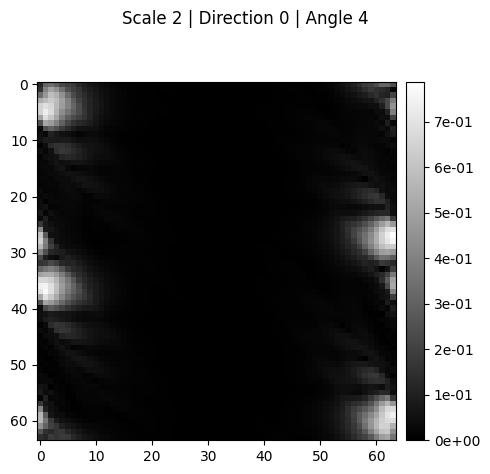

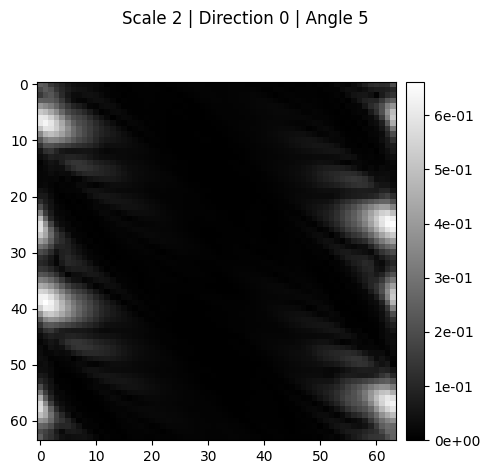

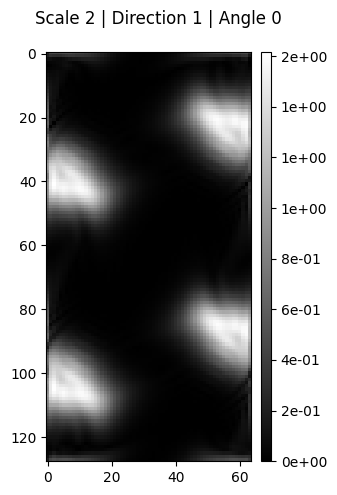

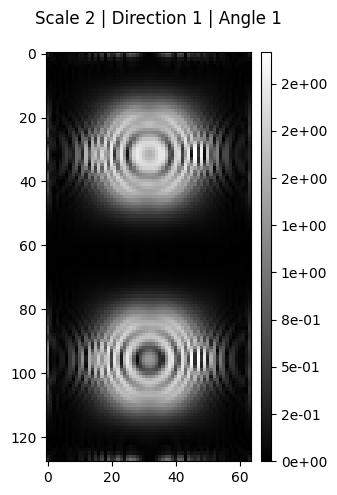

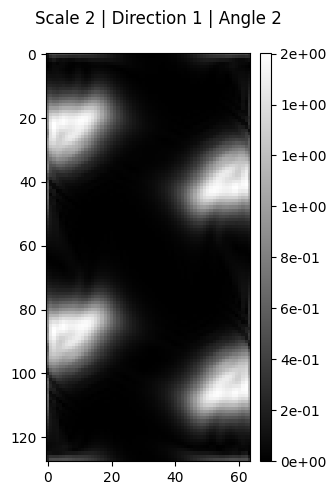

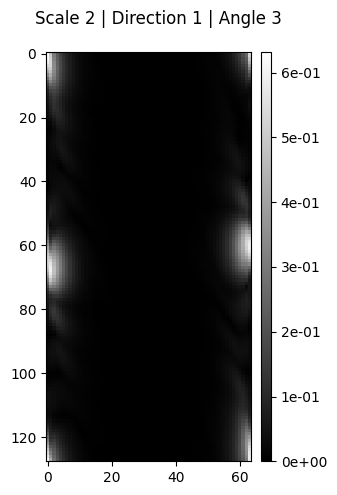

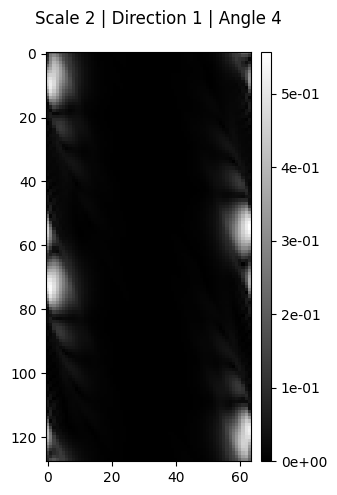

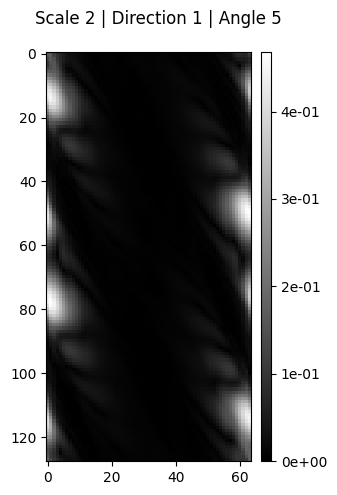

In [37]:
plt.close("all")
opts = {"aspect": "equal", "cmap": "gray"}
for i in coeffs:
    for j in coeffs[i]:
        for a in coeffs[i][j]:
            z = coeffs[i][j][a]
            opts["vmax"] = np.abs(z).max()
            opts["vmin"] = 0
            opts["cmap"] = "gray"
            fig, ax = plt.subplots(figsize=(5, 5))
            im = ax.imshow(np.abs(z).T, **opts)
            _, cb = create_colorbar(im=im, ax=ax)
            fmt = ticker.FuncFormatter(lambda x, _: f"{x:.0e}")
            cb.ax.yaxis.set_major_formatter(fmt)
            fig.suptitle(f"Scale {i} | Direction {j} | Angle {a}")
            fig.tight_layout()


In [89]:
Mdirs: dict[int, np.ndarray] = {}
dim = 3
for ires in range(C.params.res):
    Mdirs[ires] = np.zeros((dim, dim - 1), dtype=int)
    for idim in range(dim):
        Mdirs[ires][idim, :] = np.r_[range(idim), range(idim + 1, dim)]
(
    Mdirs,
    {
        ires: np.c_[
            [np.r_[np.arange(idim), np.arange(idim + 1, dim)]for idim in range(dim)]
        ]
        for ires in range(C.params.res)
    },
)

({0: array([[1, 2],
         [0, 2],
         [0, 1]]),
  1: array([[1, 2],
         [0, 2],
         [0, 1]])},
 {0: array([[1, 2],
         [0, 2],
         [0, 1]]),
  1: array([[1, 2],
         [0, 2],
         [0, 1]])})